In [20]:
from torch.nn import Conv2d
import imageio
import numpy
import skimage.transform
import torch
import torch.nn.functional as F
import matplotlib.pyplot

# Tutorial 1c. Convolution

The spatial dimensions of the ouput image (width and height) depend on the spatial dimensions of the input image, kernel_size, padding, and striding. In order to build efficient convolutional networks, it's important to understand what the sizes are after after each convolutional layer.

In this exersise you will derive the dependency between input and output image sizes. For the sake of simplicity we assume that the input tensor is _square_, i.e., width = height = image_size.

If your code is correct, you should see 'OK'.

In [21]:
def compute_conv_output_size(image_size, kernel_size, padding, stride):
    ###########################################################################
    # Add code that computes the size of the image after a conv layer.        #
    ###########################################################################
    output_size = (image_size + 2 * padding - kernel_size) // stride + 1
    output_size = max(output_size, 1)
    #output_size = (((image_size + 2 * padding)/kernel_size) + 1) / stride
    return output_size


# Compare the size of the output of nn.Conv2d with compute_convnet_output_size.
for image_size in range(5, 21, 1):
    # Shape: batch x channels x height x width.
    input_tensor = torch.zeros((1, 1, image_size, image_size))

    for kernel_size in 2, 3, 5, 7:
        for padding in 0, 5:
            for stride in 1, 2, 3, 4:
                if kernel_size >= image_size:
                    continue

                output_tensor = Conv2d(1, 1, kernel_size, stride, padding)(input_tensor)

                output_size = output_tensor.size(2)

                predicted_output_size = compute_conv_output_size(image_size, kernel_size, padding, stride)

                assert output_size == predicted_output_size, (
                    f"ERROR: the real size is {output_size},"
                    f" but got {predicted_output_size}."
                    f"\nimage_size={image_size}"
                    f" kernel_size={kernel_size}"
                    f" padding={padding}"
                    f" stride={stride}"
                )

print("OK")
compute_conv_output_size(5, 2, 1, 1)

OK


6

You can now use the function you just implemented to compute the size of the output of a convolution.

In [22]:
compute_conv_output_size(1, 1, 1, 1)

3

**Question [optional]:** Implement your own convolution operator **without** using any of PyTorch's (or numpy's) pre-defined convolutional functions.

In [27]:
def conv_naive(x, w, b, conv_param):
    """
    A naive Python implementation of a convolution.
    The input consists of an image tensor with height H and
    width W. We convolve each input with a filter F, where the filter
    has height HH and width WW.
    Input:
    - x: Input data of shape (H, W)
    - w: Filter weights of shape (HH, WW)
    - b: Bias for filter
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.
    Returns an array.
    - out: Output data, of shape (H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    """
    out = None
    H, W = x.shape
    HH, WW = w.shape
    filter_height, filter_width = w.shape
    stride, pad = conv_param["stride"], conv_param["pad"]

    # Check dimensions.
    assert (W + 2 * pad - filter_width) % stride == 0, "width does not work"
    assert (H + 2 * pad - filter_height) % stride == 0, "height does not work"

    H_out = (H + 2 * pad - HH) // stride + 1
    W_out = (W + 2 * pad - WW) // stride + 1

    x_pad = F.pad(x, (pad, pad, pad, pad))

    feature_map = torch.zeros(H_out, W_out)

    for i in range(H_out):
        for j in range(W_out):
            h_start = i * stride
            w_start = i *stride
            h_end = h_start + HH
            w_end = w_start + WW
            
            zone = x_pad[h_start:h_end, w_start:w_end]
            feature_map[i, j] = torch.sum(zone * w) + b
    return feature_map


You can test your implementation by running the following:

In [28]:
# Make convolution module.
w_shape = (4, 4)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(torch.tensor(w_shape))).reshape(w_shape)
b = torch.linspace(-0.1, 0.2, steps=1)

# Compute output of module and compare against reference values.
x_shape = (4, 4)
x = torch.linspace(-0.1, 0.5, steps=torch.prod(torch.tensor(x_shape))).reshape(x_shape)
out = conv_naive(x, w, b, {"stride": 2, "pad": 1})

correct_out = torch.tensor([[0.156, 0.162], [0.036, -0.054]])

# Compare your output to ours; difference should be around e-8
print("Testing conv_forward_naive")
rel_error = ((out - correct_out) / (out + correct_out + 1e-6)).mean()
print("difference: ", rel_error)
if abs(rel_error) < 1e-6:
    print("Nice work! Your implementation of a convolution layer works correctly.")
else:
    print(
        "Something is wrong. The output was expected to be {} but it was {}".format(
            correct_out, out
        )
    )

Testing conv_forward_naive
difference:  tensor(1.2454)
Something is wrong. The output was expected to be tensor([[ 0.1560,  0.1620],
        [ 0.0360, -0.0540]]) but it was tensor([[ 0.1560,  0.1560],
        [-0.0540, -0.0540]])


**Aside: Image processing via convolutions:**

As fun way to gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

C:\Users\alexa\AppData\Local\Temp\ipykernel_19808\4232100337.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten, puppy = imageio.imread(kitten_uri), imageio.imread(puppy_uri)


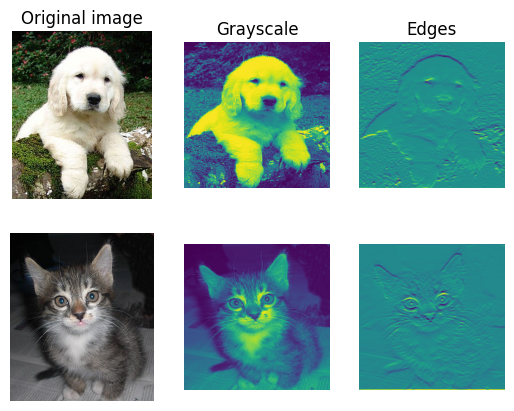

In [29]:
# Load image of a kitten and a puppy.
kitten_uri = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Persian_Cat_%28kitten%29.jpg/256px-Persian_Cat_%28kitten%29.jpg"
puppy_uri = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Golde33443.jpg/256px-Golde33443.jpg"
kitten, puppy = imageio.imread(kitten_uri), imageio.imread(puppy_uri)

img_size = 200  # Make this smaller if it runs too slow
x = numpy.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = skimage.transform.resize(puppy, (img_size, img_size)).transpose(
    (2, 0, 1)
)
x[1, :, :, :] = skimage.transform.resize(kitten, (img_size, img_size)).transpose(
    (2, 0, 1)
)
x = torch.FloatTensor(x)

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros((2, 3, 3, 3), dtype=torch.float)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=torch.float)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out = F.conv2d(x, w, b, stride=1, padding=1).numpy()


def imshow_noax(img, normalize=True):
    """Tiny helper to show images as uint8 and remove axis labels."""
    if normalize:
        img_max, img_min = numpy.max(img), numpy.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    matplotlib.pyplot.imshow(img.astype("uint8"))
    matplotlib.pyplot.gca().axis("off")


# Show the original images and the results of the conv operation
matplotlib.pyplot.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
matplotlib.pyplot.title("Original image")
matplotlib.pyplot.subplot(2, 3, 2)
imshow_noax(out[0, 0])
matplotlib.pyplot.title("Grayscale")
matplotlib.pyplot.subplot(2, 3, 3)
imshow_noax(out[0, 1])
matplotlib.pyplot.title("Edges")
matplotlib.pyplot.subplot(2, 3, 4)
imshow_noax(kitten, normalize=False)
matplotlib.pyplot.subplot(2, 3, 5)
imshow_noax(out[1, 0])
matplotlib.pyplot.subplot(2, 3, 6)
imshow_noax(out[1, 1])
matplotlib.pyplot.show()